# LIME-Aleph

### KI-Campus Aufgabe

Willkommen zum Arbeitsauftrag für das Modul __LIME-Aleph__ im KI-Campus. Hier werden Sie den typischen Ablauf zum Finden einer symbolischen Erklärung für Black-Box Netzwerke mithilfe der LIME-Aleph Bibliothek Stück für Stück erarbeiten.

Wir wollen zunächst mal die nötigen Bibliotheken importieren und einige nutzerdefinierbare Parameter erzeugen. Eine zu klassifizierende Bilddatei sowie ein vortrainiertes Modell sind schon vorhanden.

In [1]:
from skimage.util import img_as_float32
from skimage.transform import resize
from train_model import own_rel
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
from skimage import io
from skimage.io import imshow, show, imsave
import shutil

import lime_aleph as la


IMAGE_FILE = "./pos9000.png" # The path to the image file to be classified by the black-box
MODEL = "../models_to_explain/model_tower.h5" # The path to the pre-trained model
K = 3 # The number of important superpixels to be used for perturbation
N = 1000 # The sample size for LIME
OUTPUT_DIR = "../output/" # A path for a directory to save intermediate and output data
T = 0.8 # The threshold for the binary classifier for when an example is classified as 'positive'
NOISE = 10 # The allowed false-positive rate for Aleph in percent.

Sollte es noch temporäre Daten aus früheren Durchläufen geben, sollen diese nun gelöscht werden:

In [2]:
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
os.makedirs(OUTPUT_DIR)

Nun wollen wir das Bild und das vortrainierte Modell in den Speicher laden:

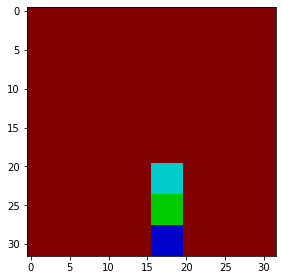

In [3]:
image = img_as_float32(io.imread(IMAGE_FILE))
image = resize(image, (own_rel.IMAGE_SIZE, own_rel.IMAGE_SIZE), anti_aliasing=True)

model = own_rel.own_rel()
model.load_weights(MODEL)

io.imshow(image)
io.show()

Der nächste Schritt soll nun sein, die im Bild vorhandenen Elemente automatisch zu annotieren. Benutzen Sie hierfür die Funktion __annotate_image_parts__ aus dem bereits importierten __lime_aleph__ package mit den benötigten Parametern:

In [4]:
annotated_image = la.annotate_image_parts(image, model, OUTPUT_DIR, N)

Running LIME...
True class of the image is:  1
Negative estimator: 0.023822417
Positive estimator: 0.9761776
Starting the explanation generation process. This may take several minutes. Seriously. Grab a cup of coffee.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



Intercept -0.20280486275716522
Prediction_local [0.31627629]
Right: 0.023822423
Intercept 1.2028048627167234
Prediction_local [0.68372371]
Right: 0.9761776
Elapsed time: 2.4895732402801514
Number of superpixels: 64
Annotating the superpixels...
Weight of sp:  44 is:  0.12419629683933532
Weight of sp:  60 is:  0.11501543664701494
Weight of sp:  52 is:  0.11038034063954716
Weight of sp:  26 is:  -0.04124681698052051
Weight of sp:  18 is:  -0.03935497534735091
Weight of sp:  20 is:  -0.03863107114929205
Weight of sp:  32 is:  -0.03675748619585719
Weight of sp:  33 is:  -0.03196233656160736
Weight of sp:  21 is:  -0.030046817512787823
Weight of sp:  14 is:  -0.027722160536166673
Weight of sp:  48 is:  -0.02736746523505049
Weight of sp:  5 is:  0.02677362057665112
Weight of sp:  35 is:  -0.026602177835968188
Weight of sp:  12 is:  -0.025736433444713457
Weight of sp:  25 is:  -0.02510378547877642
Weight of sp:  50 is:  -0.024711291494698102
Weight of sp:  6 is:  -0.02420615925003589
Weight 

Nachdem das Bild nun annotiert ist (als Annotation wurden auch die Gewichte von LIME für die einzelnen Elemente gefunden), können wir nun die wichtigsten __K__ Bildelemente mit der Funktion __find_important_parts__ finden. Anschließend können Sie auch die Relationen zwischen den Bildteilen mit der Funktion __find_spatial_relations__ finden lassen:

In [7]:
important_superpixels = la.find_important_parts(annotated_image, K)
relations = la.find_spatial_relations(important_superpixels)

Currently at superpixel 44
Currently at superpixel 60
Currently at superpixel 52


Die Liste, welche von der Funktion zum Finden von Relationen zurückgegeben wurde, beinhaltet Objekte vom Typ __Relation__. Hier geben wir nun beispielhaft die Informationen der ersten Relation aus. Natürlich müssen Sie den Namen der Liste an Ihre Implementation anpassen.

In [8]:
print("Name:", relations[0].name)
print("Start:", relations[0].start)
print("To:", relations[0].to)

Name: bottom_of
Start: 60
To: 44


Der Name beschreibt das Prädikat der räumlichen Relation. Die weiteren Informationen beschreiben die Indices der Start- und Zielelemente der Relation innerhalb des Bildes.

Nun wollen wir das perturbierte Datenset für LIME-Aleph generieren lassen. Benutzen Sie hierzu die Funktion __perturb_instance__ mit den erforderlichen Parametern. Lassen Sie sich auch ausgeben, wie viele Instanzen im neuen Datenset sind (Es wird eine Liste mit Instanzen zurückgegeben).

In [9]:
perturbed_dataset = la.perturb_instance(annotated_image, relations, model, T)

In [10]:
print("Number of perturbed instances:", len(perturbed_dataset))

Number of perturbed instances: 11


Das ILP-Framework Aleph benötigt mehrere Hilfsdateien, die mit der Funktion __write_aleph_files__ erzeugt werden. Rufen Sie diese Funktion auf. Es sollen alle räumlichen Relationen verwendet werden! Zur Verfügung stehen folgende Relationen: *left_of*, *right_of*, *top_of*, *bottom_of*, *on*, *under*

In [12]:
used_relations = None
la.write_aleph_files(annotated_image, perturbed_dataset, used_relations, OUTPUT_DIR, NOISE)

Writing the input files for Aleph...
Done.


Schlussendlich muss nun der Induktionsprozess von Aleph angestoßen werden. Dieser Schritt (mit der Funktion __run_aleph__) gibt auch die gefundene Erklärung aus:

In [13]:
la.run_aleph(OUTPUT_DIR)

[{}]
[{}]
[{}]
[{}]
[{}]
The explanation was saved to '../output/explanation.txt'


Die Erklärung in Form von Regeln kann nun im angegebenen Ordner in der Datei *explanation.txt* gefunden und interpretiert werden. Wir lesen nun diese Datei aus:

In [14]:
with open(OUTPUT_DIR + "explanation.txt", 'r') as f:
    print(f.read())

true_class(A) :-
   contains(B,A), contains(C,A), has_color(C,lime), on_in_ex(C,B,A).

